# Random Forest Regressor and Robustness Checks

## Preparation

In [3]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer

In [4]:
# read in dataset
data = pd.read_csv("dissertation_dataset.csv")

## Random Forst Regressor

In [6]:
# create lagged GDP by country
data['gdp_lag1'] = data.groupby('country')['gdp'].shift(1)

# define predictors
predictors = ['hdi', 'gdp_lag1', 'infant_mort', 'unemployment', 'wgi']

# scale predicors
scaler = StandardScaler() 
data[predictors] = scaler.fit_transform(data[predictors])

# define X
X = data[predictors]
# define y (logged)
y = np.log1p(data['homicide_ratio'])
# Remember to exponentiate predictions later: np.expm1(y_pred)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define country-year features
groups = data['country']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(data, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [7]:
# run model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# error metrics 
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")


RMSE: 0.97
MAE: 0.75
R²: 0.159


In [8]:
# back-transform RMSE/MAE in original homicide units
y_pred_exp = np.expm1(y_pred)
y_test_exp = np.expm1(y_test)

print("RMSE (Original scale):", mean_squared_error(y_test_exp, y_pred_exp))
print("MAE (Original scale):", mean_absolute_error(y_test_exp, y_pred_exp))


RMSE (Original scale): 214.1782344117122
MAE (Original scale): 7.565647822319519


In [9]:
# feature importances
importances = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)
print("\nFeature Importances:")
print(importances)


Feature Importances:
infant_mort     0.481602
gdp_lag1        0.172838
wgi             0.141419
unemployment    0.131612
hdi             0.072528
dtype: float64


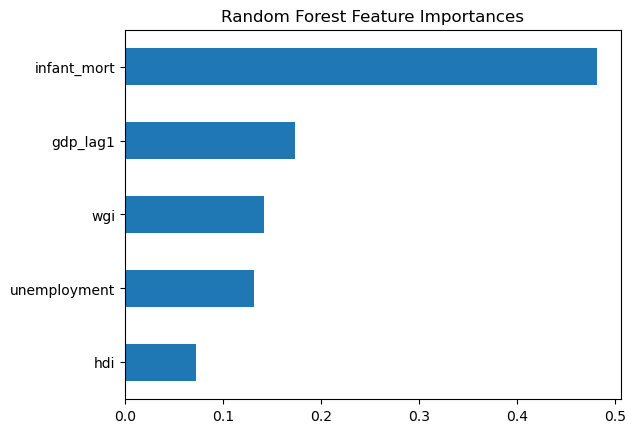

In [10]:
#plot feature importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values()
feat_imp.plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.show()

### Partial Dependence Plots

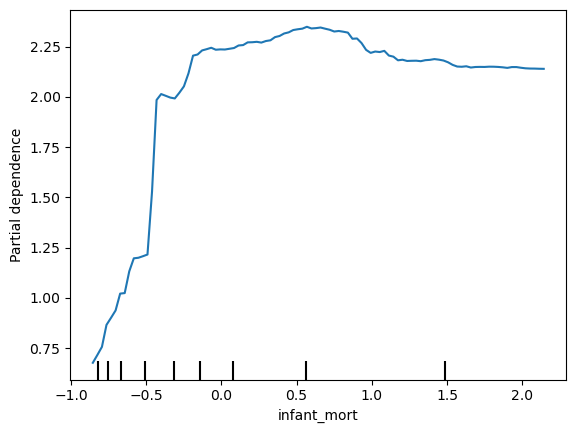

In [12]:
# plot infant mortality:
PartialDependenceDisplay.from_estimator(rf, X, ['infant_mort'])
plt.show()


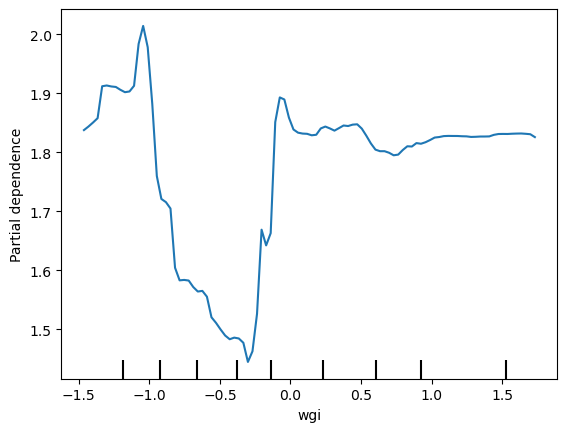

In [13]:
# plot WGI:
PartialDependenceDisplay.from_estimator(rf, X, ['wgi'])
plt.show()

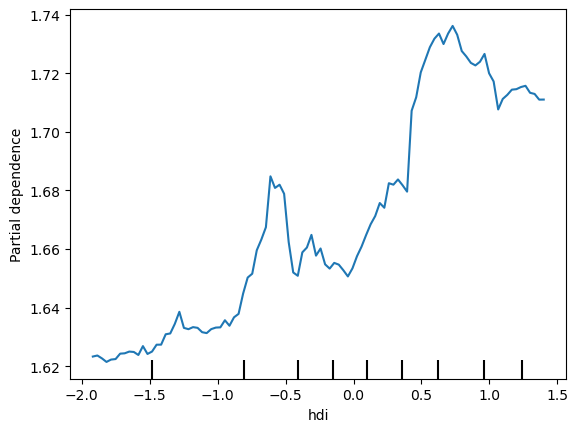

In [14]:
# plot HDI:
PartialDependenceDisplay.from_estimator(rf, X, ['hdi'])
plt.show()

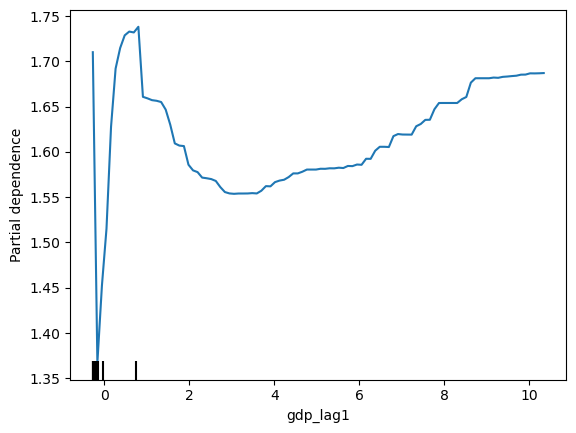

In [15]:
# plot lagged GDP:
PartialDependenceDisplay.from_estimator(rf, X, ['gdp_lag1'])
plt.show()

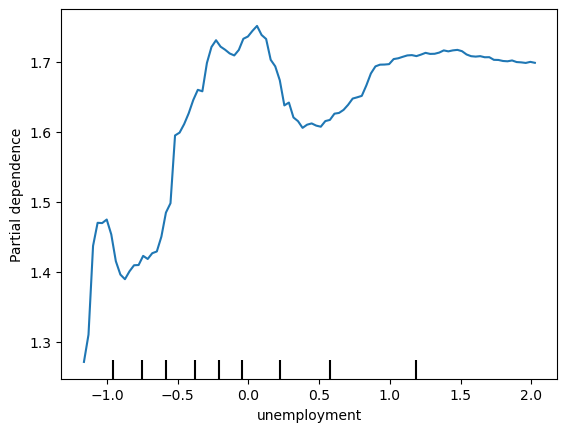

In [16]:
# plot unemployment rate:
PartialDependenceDisplay.from_estimator(rf, X, ['unemployment'])
plt.show()

## Robustness Checks

## K-fold Crossvalidation

In [18]:
# define X, y, and groups
X = data[predictors]
y = np.log1p(data['homicide_ratio'])
# Remember to exponentiate predictions later: np.expm1(y_pred)
groups = data['country']

# initialize model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# cross-validation
gkf = GroupKFold(n_splits=5)
r2_scores = []
rmse_scores = []

for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    r2_scores.append(r2_score(y_test, y_pred))
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))


# error metrices
print("Average R²:", np.mean(r2_scores))
print("Average RMSE:", np.mean(rmse_scores))
print("Fold R² scores:", r2_scores)


Average R²: 0.3035095912903906
Average RMSE: 11.812998999211054
Fold R² scores: [0.5570265880203509, 0.14837065613742695, -0.052244423684870034, 0.5623926582060237, 0.3020024777730218]


## Permutation

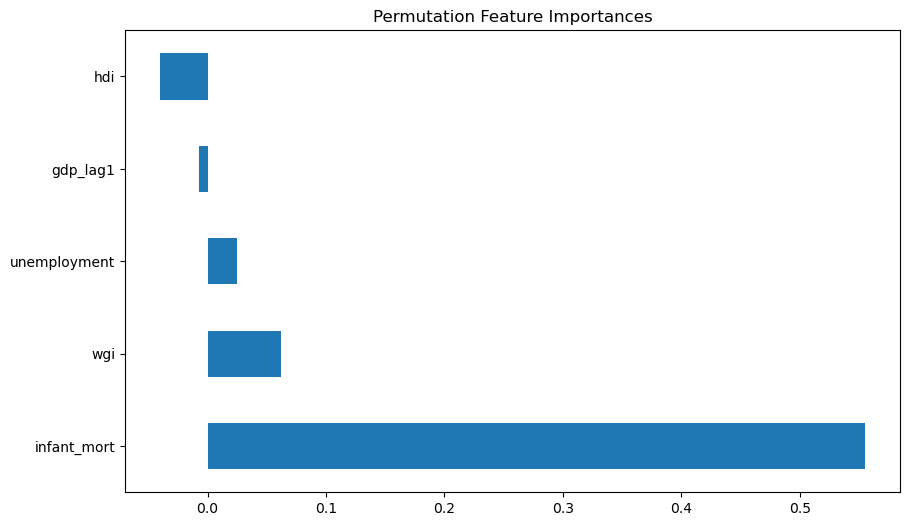

In [20]:
# run permutation
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# show top features
importances = pd.Series(result.importances_mean, index=X.columns)
importances.sort_values(ascending=False).plot(kind="barh", figsize=(10,6))
plt.title("Permutation Feature Importances")
plt.show()


## Ridge Regression

In [22]:
# define variables
predictors = predictors = ['hdi', 'gdp_lag1', 'infant_mort', 'unemployment', 'wgi']
target = 'homicide_ratio'

# impute anything still missing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(data[predictors])

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# log-transform y
y = np.log1p(data[target])

# group shuffle, train-test split
groups = data['country']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X_scaled, groups=groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# run ridge regression on test part 
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

#metrics
rmse_log = mean_squared_error(y_test, y_pred)
mae_log = mean_absolute_error(y_test, y_pred)
r2_log = r2_score(y_test, y_pred)

# back-transform into original scale
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)

rmse_orig = mean_squared_error(y_test_orig, y_pred_orig)
mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)

# results
print("=== Log-transformed target ===")
print(f"RMSE (log scale): {rmse_log:.3f}")
print(f"MAE (log scale): {mae_log:.3f}")
print(f"R² (log scale): {r2_log:.3f}\n")

print("=== Original scale ===")
print(f"RMSE (original): {rmse_orig:.2f}")
print(f"MAE (original): {mae_orig:.2f}")

=== Log-transformed target ===
RMSE (log scale): 0.866
MAE (log scale): 0.738
R² (log scale): 0.248

=== Original scale ===
RMSE (original): 227.22
MAE (original): 7.60
